# data format

### 说明

### refs
+ https://cloud.tencent.com/developer/article/1581218
+ https://blog.csdn.net/ViatorSun/article/details/124562686
+ https://www.cnblogs.com/pioner/p/16665363.html
+ https://blog.csdn.net/u011119817/article/details/119004535
+ https://blog.csdn.net/qq_21386397/article/details/123656072

+ yolo/voc/coco格式

+ yolo格式：
    label c_x c_y w h
    label c_x c_y w h
+ voc格式：
    xmin，ymin，xmax，ymax
    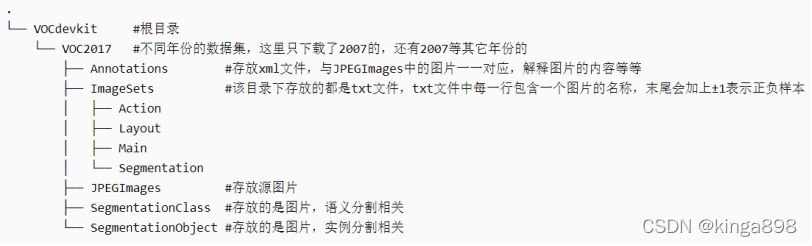
+ coco格式：
    xmin ymin w h

### import

In [ ]:
#! /usr/bin/env python
# coding: utf-8
import os, sys
from copy import deepcopy
import cv2
import numpy as np
import copy
from lxml.etree import Element, SubElement, tostring, ElementTree

import xml.etree.ElementTree as ET
import pickle
from os import listdir, getcwd
from os.path import join
import json
import glob

## yolo to voc

### func-yolo2voc

In [ ]:
class Yolo2Voc():
    '''
    yolo format:
        yolo_data_dir
            labels
            images
        labels中文件与images中文件名同名
        labels中XXX.txt: cls x y x y ...
    '''
    def __init__(self, yolo_path, voc_path, lables, norm=False) -> None:
        self.yolo_path = yolo_path
        self.voc_path = voc_path
        self.lables = lables
        self.norm = norm
        self.mkdir_voc()
    
    def mkdir_voc(self):
        os.makedirs(os.path.join(self.voc_path, 'JPEGImages'), exist_ok=True)
        os.makedirs(os.path.join(self.voc_path, 'Annotations'), exist_ok=True)
        os.makedirs(os.path.join(self.voc_path, 'ImageSets'), exist_ok=True)
    
    def translate(self, copy_image=False):
        xml_head = '''<annotation>
            <folder>VOC2007</folder>
            <filename>{}</filename>
            <source>
                <database>The VOC2007 Database</database>
                <annotation>PASCAL VOC2007</annotation>
                <image>flickr</image>
            </source>
            <size>
                <width>{}</width>
                <height>{}</height>
                <depth>{}</depth>
            </size>
            <segmented>0</segmented>
            '''
        xml_obj = '''
            <object>        
                <name>{}</name>
                <pose>Rear</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                    <xmin>{}</xmin>
                    <ymin>{}</ymin>
                    <xmax>{}</xmax>
                    <ymax>{}</ymax>
                </bndbox>
            </object>
            '''
        xml_end = '''
        </annotation>'''

        cnt = 0
        txt_path = os.path.join(self.yolo_path, 'labels')  # yolo存放txt的文件目录
        image_path = os.path.join(self.yolo_path, 'images')  # 存放图片的文件目录
        path = os.path.join(self.voc_path, 'Annotations')  # 存放生成xml的文件目录
        voc_image_path = os.path.join(self.voc_path, 'JPEGImages')

        for (root, dirname, files) in os.walk(image_path):  # 遍历图片文件夹
            for ft in files:
                basename = os.path.basename(ft)
                name, ext = os.path.splitext(basename)
                ftxt = ft.replace(ext, '.txt')  # ft是图片名字+扩展名，将jpg和txt替换
                fxml = ft.replace(ext, '.xml')
                xml_path = os.path.join(path, fxml)
                obj = ''

                img_file = os.path.join(root, ft)
                img = cv2.imread(img_file)
                img_h, img_w = img.shape[0], img.shape[1]
                head = xml_head.format(str(fxml), str(img_w), str(img_h), 3)

                with open(os.path.join(txt_path, ftxt), 'r') as f:  # 读取对应txt文件内容
                    for line in f.readlines():
                        yolo_datas = line.strip().split(' ')
                        label = int(float(yolo_datas[0].strip()))
                        if self.norm:
                            center_x = round(float(str(yolo_datas[1]).strip()) * img_w)
                            center_y = round(float(str(yolo_datas[2]).strip()) * img_h)
                            bbox_width = round(float(str(yolo_datas[3]).strip()) * img_w)
                            bbox_height = round(float(str(yolo_datas[4]).strip()) * img_h)
                        else:
                            center_x = round(float(str(yolo_datas[1]).strip()))
                            center_y = round(float(str(yolo_datas[2]).strip()))
                            bbox_width = round(float(str(yolo_datas[3]).strip()))
                            bbox_height = round(float(str(yolo_datas[4]).strip()))
                        print(f'{yolo_datas=}')
                        print(f'{label=}  {center_x=}  {center_y=}  {bbox_width=}  {bbox_height=}')

                        xmin = str(int(center_x - bbox_width / 2))
                        ymin = str(int(center_y - bbox_height / 2))
                        xmax = str(int(center_x + bbox_width / 2))
                        ymax = str(int(center_y + bbox_height / 2))
                        print(f'{xmin=}  {ymin=}  {xmax=}  {ymax=}')
                        obj += xml_obj.format(self.lables[label], xmin, ymin, xmax, ymax)
                with open(xml_path, 'w') as f_xml:
                    f_xml.write(head + obj + xml_end)
                
                if copy_image:
                    cv2.imwrite(os.path.join(voc_image_path, basename), img)
                cnt += 1
                print(cnt)

        classes_string = '\n'.join(self.lables)
        voc_classes_file = os.path.join(self.voc_path, 'voc_classes.txt')
        with open(voc_classes_file, 'w') as df:
            df.writelines(classes_string)
            df.flush()


### convert

In [ ]:
yolo_path = r'/home/yangliwei/code/PyUtils/PyUtils/test/test_data_format/yolo'
voc_path = r'/home/yangliwei/code/PyUtils/PyUtils/test/test_data_format/voc'
coco_path = r'/home/yangliwei/dataset/voc2coco'
labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


# test yolo to voc
yolo2voc = Yolo2Voc(yolo_path=yolo_path, voc_path=voc_path, lables=labels)
yolo2voc.translate(copy_image=True)


## voc to yolo

#### func-voc2yolo

In [ ]:
################################################################################
# refs:
#   voc2yolo: https://blog.csdn.net/qq_43791139/article/details/127306675
#   https://zhuanlan.zhihu.com/p/160103709
################################################################################

class Voc2Yolo():
    '''
    yolo format:
        yolo_data_dir
            labels
            images
        labels中文件与images中文件名同名
        labels中XXX.txt: cls x y x y ...
    '''
    def __init__(self, yolo_path, voc_path, classes, norm=False) -> None:
        self.yolo_path = yolo_path
        self.voc_path = voc_path
        self.norm = norm
        self.classes = classes
        self.mkdir_yolo()

    def mkdir_yolo(self):
        os.makedirs(os.path.join(self.yolo_path, 'images'), exist_ok=True)
        os.makedirs(os.path.join(self.yolo_path, 'labels'), exist_ok=True)

    def convert_annotation(self, image_id):
        in_file = open(os.path.join(self.voc_path, 'Annotations', image_id + '.xml'), encoding='UTF-8')  # xml文件路径

        out_file = open(os.path.join(self.yolo_path, 'labels', image_id+'.txt'), 'w')  # 生成txt格式文件
        tree = ET.parse(in_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)

        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in self.classes:
                continue
            cls_id = self.classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text),
                float(xmlbox.find('ymax').text))
            bb = self.convert((w, h), b)
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
    
    def convert(self, size, box):
        dw = 1. / size[0]
        dh = 1. / size[1]
        x = (box[0] + box[1]) / 2.0
        y = (box[2] + box[3]) / 2.0
        w = box[1] - box[0]
        h = box[3] - box[2]
        if self.norm:
            x = x * dw
            w = w * dw
            y = y * dh
            h = h * dh
        return (x, y, w, h)

    def translate(self, copy_image=False):

        voc_xml_path = os.path.join(self.voc_path, 'Annotations')
        voc_img_path = os.path.join(self.voc_path, 'JPEGImages')

        # xml list
        img_xmls = os.listdir(voc_xml_path)
        for img_xml in img_xmls:
            print(f'{img_xml=}')
            label_name = img_xml.split('.')[0]
            print(f'{label_name=}')
            self.convert_annotation(label_name)

            if copy_image:
                voc_img_file = os.path.join(self.voc_path, 'JPEGImages', label_name+'.jpg')
                yolo_img_file = os.path.join(self.yolo_path, 'images', label_name+'.jpg')
                os.system(f'cp {voc_img_file} {yolo_img_file}')
                
    
        classes_string = '\n'.join(self.classes)
        yolo_classes_file = os.path.join(self.yolo_path, 'yolo_classes.txt')
        with open(yolo_classes_file, 'w') as df:
            df.writelines(classes_string)
            df.flush()

### convert

In [ ]:
yolo_path = r'/home/yangliwei/code/PyUtils/PyUtils/test/test_data_format/yolo'
voc_path = r'/home/yangliwei/code/PyUtils/PyUtils/test/test_data_format/voc'
coco_path = r'/home/yangliwei/dataset/voc2coco'
labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


# test voc to yolo
voc2yolo = Voc2Yolo(yolo_path=yolo_path, voc_path=voc_path, classes=labels)
voc2yolo.translate(copy_image=True)


## voc to coco

#### func-voc2coco

In [ ]:

class Voc2COCO():
    def __init__(self, voc_path, coco_path, classes, folders=['train', 'test', 'val'], start_id=0) -> None:
        self.voc_path = voc_path
        self.coco_path = coco_path
        self.folders = folders
        self.start_id = start_id
        self.classes = classes
        self.mkdir_coco()
        self.START_BOUNDING_BOX_ID = 1
        # ****** 注意：此处categories id必须与pred的dt中的categories id一致 ******
        self.PRE_DEFINE_CATEGORIES = {k: v+1 for v, k in enumerate(self.classes)}

    def mkdir_coco(self):
        os.makedirs(os.path.join(self.coco_path, 'annotations'), exist_ok=True)
        os.makedirs(os.path.join(self.coco_path, 'train'), exist_ok=True)
        os.makedirs(os.path.join(self.coco_path, 'test'), exist_ok=True)
        os.makedirs(os.path.join(self.coco_path, 'val'), exist_ok=True)

    def get(self, root, name):
        vars = root.findall(name)
        return vars

    def get_and_check(self, root, name, length):
        vars = root.findall(name)
        print(f'{vars[0].text=}  {name=}')
        if len(vars) == 0:
            raise NotImplementedError('Can not find %s in %s.' % (name, root.tag))
        if length > 0 and len(vars) != length:
            raise NotImplementedError('The size of %s is supposed to be %d, but is %d.' % (name, length, len(vars)))
        if length == 1:
            vars = vars[0]
        return vars

    def get_filename_as_int(self, filename):
        try:
            filename = os.path.splitext(filename)[0]
            return (filename)
        except:
            raise NotImplementedError('Filename %s is supposed to be an integer.' % (filename))


    def convert(self, xml_dir, json_file, filter=None):
        xmlFiles = os.listdir(xml_dir)

        json_dict = {"images": [], "type": "instances", "annotations": [],
                    "categories": []}
        categories = self.PRE_DEFINE_CATEGORIES
        bnd_id = self.START_BOUNDING_BOX_ID
        num = 0
        for line in xmlFiles:
            if not line.endswith('.xml'):
                continue
            self.start_id += 1
            num += 1
            if num % 50 == 0:
                print("processing ", num, "; file ", line)

            xml_f = os.path.join(xml_dir, line)
            print(f'{xml_f=}')
            tree = ET.parse(xml_f)
            root = tree.getroot()
            # The filename must be a number
            filename = line[:-4]
            print(f'{filename=}  {len(filter)=}')
            if (filter is not None) and (filename not in filter):
                continue
                
            image_id = self.get_filename_as_int(filename)
            size = self.get_and_check(root, 'size', 1)
            width = int(self.get_and_check(size, 'width', 1).text)
            height = int(self.get_and_check(size, 'height', 1).text)
            # image = {'file_name': filename, 'height': height, 'width': width,
            #          'id':image_id}
            image = {'file_name': (filename + '.jpg'), 'height': height, 'width': width,
                    'id': self.start_id}
            json_dict['images'].append(image)
            # Cruuently we do not support segmentation
            #  segmented = get_and_check(root, 'segmented', 1).text
            #  assert segmented == '0'
            for obj in self.get(root, 'object'):
                category = self.get_and_check(obj, 'name', 1).text
                if category not in categories:
                    new_id = max(categories.values()) + 1
                    categories[category] = new_id
                category_id = categories[category]
                bndbox = self.get_and_check(obj, 'bndbox', 1)
                xmin = int(float(self.get_and_check(bndbox, 'xmin', 1).text)) - 1
                ymin = int(float(self.get_and_check(bndbox, 'ymin', 1).text)) - 1
                xmax = int(float(self.get_and_check(bndbox, 'xmax', 1).text))
                ymax = int(float(self.get_and_check(bndbox, 'ymax', 1).text))
                assert (xmax > xmin)
                assert (ymax > ymin)
                o_width = abs(xmax - xmin)
                o_height = abs(ymax - ymin)
                print(f'{xmin=}  {ymin=}  {xmax=}  {ymax=}  {o_width=}  {o_height=}')
                ann = {'area': o_width * o_height, 'iscrowd': 0, 'image_id':
                    self.start_id, 'bbox': [xmin, ymin, o_width, o_height],
                    'category_id': category_id, 'id': bnd_id, 'ignore': 0,
                    'segmentation': []}
                json_dict['annotations'].append(ann)
                bnd_id = bnd_id + 1

        for cate, cid in categories.items():
            cat = {'supercategory': 'none', 'id': cid, 'name': cate}
            json_dict['categories'].append(cat)
        json_fp = open(json_file, 'w')
        json_str = json.dumps(json_dict)
        json_fp.write(json_str)
        json_fp.close()
    
    def translate(self, copy_image=False):
        for folder, voc_folder in zip(self.folders, self.voc_path):
            folderName = folder
            xml_dir = os.path.join(voc_folder, 'Annotations')
            json_dir = os.path.join(self.coco_path, 'annotations', f"instances_{folderName}.json")
            print("deal: ", folderName)
            print("xml dir: ", xml_dir)
            print("json file: ", json_dir)
            self.convert(xml_dir, json_dir)
            
            if copy_image:
                voc_img_dir = os.path.join(voc_folder, 'JPEGImages')
                coco_img_dir = os.path.join(self.coco_path, folder)
                imgs = glob.glob(os.path.join(voc_img_dir, "*.jpg"))
                print(f'copy from {voc_img_dir} [{len(imgs)}] to {coco_img_dir}')
                for idx, img in enumerate(imgs):
                    os.system(f'cp {img} {coco_img_dir}')
                    if idx % 100 == 0:
                        print(f'copying [{len(imgs)}/{idx}] ...  ')
      
      
    
    def translate_folder(self, copy_image=False):
        for folder, voc_folder in zip(self.folders, self.voc_path):
            folderName = folder
            xml_dir = os.path.join(voc_folder, 'Annotations')
            json_dir = os.path.join(self.coco_path, 'annotations', f"instances_{folderName}.json")
            mode_txt = os.path.join(voc_folder, 'ImageSets', 'Main', f'{folder}.txt')
            print("deal: ", folderName)
            print("xml dir: ", xml_dir)
            print("json file: ", json_dir)
            print("mode file: ", mode_txt)
            
            lines = None
            with open(mode_txt, 'r') as lf:
                lines = lf.readlines()
            lines = [line.strip() for line in lines]
            
            self.convert(xml_dir, json_dir, lines)
            
            if copy_image:
                voc_img_dir = os.path.join(voc_folder, 'JPEGImages')
                coco_img_dir = os.path.join(self.coco_path, folder)
                print(f'copy from {voc_img_dir} [{len(lines)}] to {coco_img_dir}')
                for idx, img_id in enumerate(lines):
                    img = os.path.join(voc_img_dir, f'{img_id}.jpg')
                    os.system(f'cp {img} {coco_img_dir}')
                    if idx % 100 == 0:
                        print(f'copying [{len(lines)}/{idx}] ...  ')


### convert

In [ ]:
## ****** 此处label与pred过程label一致 ******
labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

## test voc to coco
voc_path = r'/data/ylw/dataset/voc/VOCdevkit/VOC2007'
coco_path = r'/data/ylw/dataset/voc2coco'
folders=['test']
voc2coco = Voc2COCO(voc_path=[voc_path], coco_path=coco_path, classes=labels, folders=folders)
# voc2coco.translate(copy_image=True)
voc2coco.translate_folder(copy_image=True)